# Project: Translator with Transformer (Korean to English)

## Rubric

### 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.	
    데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.
### 2. Transformer 번역기 모델이 정상적으로 구동된다.	
    Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
### 3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	
    제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from tqdm import tqdm
from tqdm import tqdm_notebook
import random

import sentencepiece as spm
from konlpy.tag import Mecab

In [2]:
import os
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)  # kor, eng가 같은 갯수라는 것을 검증받기 위해 적용
    
    cleaned_corpus = list(set(zip(kor, eng)))  # 중복된 데이터 제거
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [3]:
def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환
    sentence = sentence.lower()
    # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)
    # 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 문장 앞뒤의 불필요한 공백 제거
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence

In [4]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):

# corpus를 받아 txt 파일로 저장
    temp_file = os.getenv('HOME') + f'/aiffel/transformer/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    # Sentencepiece
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=/aiffel/aiffel/transformer/spm_{lang} --vocab_size={vocab_size}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'/aiffel/aiffel/transformer/spm_{lang}.model')

    return tokenizer

In [5]:
cleaned_corpus[0]

('나에겐 전폭적인 지지를 아끼지 않는 사랑하는 가족이 있다.',
 "... I have a really wonderful family that's very supportive.")

In [6]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k, e in cleaned_corpus:
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/corpus_ko.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=/aiffel/aiffel/transformer/spm_ko --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/corpus_ko.txt
  input_format: 
  model_prefix: /aiffel/aiffel/transformer/spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
 

True

In [7]:
from tqdm import notebook  # Process 과정을 보기 위해
import tensorflow as tf

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in notebook.tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)


# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

## Model creation

In [8]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)  # np.power(a,b) > a^b(제곱)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [10]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out

In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        # Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [12]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        #out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        # Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        #out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

In [15]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        # 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        # 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [16]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

## Learning utils

In [17]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [18]:
learning_rate = LearningRateScheduler(256)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [19]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [34]:
# Initialize before learning new model

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [21]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [22]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        
        # InvalidArgumentError: In[0] mismatch In[1] shape: 50 vs. 1: [1,8,1,50] [1,8,1,64] 0 0 [Op:BatchMatMulV2]
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [23]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [24]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

## Learning part

### n_layers=2

In [25]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

In [26]:
# 학습
EPOCHS = 20
BATCH_SIZE = 32

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                                                     dec_train[idx:idx+BATCH_SIZE],
                                                                     transformer,
                                                                     optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    # 매 Epoch 마다 제시된 예문에 대한 번역 생성
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

Epoch  1: 100%|██████████| 2255/2255 [03:54<00:00,  9.61it/s, Loss 5.3521] 


Input: 오바마는 대통령이다.
Predicted translation: obama is not a way .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is the most powerful .
Input: 커피는 필요 없다.
Predicted translation: there is no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nearly , people died in nearby .


Epoch  2: 100%|██████████| 2255/2255 [03:41<00:00, 10.19it/s, Loss 4.2860]


Input: 오바마는 대통령이다.
Predicted translation: it is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city of cities , city officials are in the city of the city .
Input: 커피는 필요 없다.
Predicted translation: coffee did not be upper .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a number of dead were killed .


Epoch  3: 100%|██████████| 2255/2255 [03:41<00:00, 10.20it/s, Loss 3.7527]


Input: 오바마는 대통령이다.
Predicted translation: obama is the third base of obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the crowds are in the city of manhattan .
Input: 커피는 필요 없다.
Predicted translation: coffee is needed to because it is difficult .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were killed .


Epoch  4: 100%|██████████| 2255/2255 [03:40<00:00, 10.21it/s, Loss 3.1365]


Input: 오바마는 대통령이다.
Predicted translation: president obama is a key question
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are also left to the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is nothing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , seven people killed in the deadly shooting .


Epoch  5: 100%|██████████| 2255/2255 [03:40<00:00, 10.21it/s, Loss 2.5885]


Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: some is a city of city .
Input: 커피는 필요 없다.
Predicted translation: the coffee house is nothing wrong .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven died wednesday at the scene .


Epoch  6: 100%|██████████| 2255/2255 [03:40<00:00, 10.21it/s, Loss 2.0845]


Input: 오바마는 대통령이다.
Predicted translation: obama is the strongest man in the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the city is mountain .
Input: 커피는 필요 없다.
Predicted translation: the coffee house s biggest coffee was not a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were wounded thursday .


Epoch  7: 100%|██████████| 2255/2255 [03:41<00:00, 10.19it/s, Loss 1.6407]


Input: 오바마는 대통령이다.
Predicted translation: obama is the second presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the city s cities is building in the town .
Input: 커피는 필요 없다.
Predicted translation: the coffee house does not know each other .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were seven died in the burned clashes .


Epoch  8: 100%|██████████| 2255/2255 [03:41<00:00, 10.20it/s, Loss 1.2829]


Input: 오바마는 대통령이다.
Predicted translation: obama is projected to be president of president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are thought to be in the city .
Input: 커피는 필요 없다.
Predicted translation: if there is no known casualties .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are dead , according to the iraqi army s death sunday .


Epoch  9: 100%|██████████| 2255/2255 [03:41<00:00, 10.20it/s, Loss 1.0138]


Input: 오바마는 대통령이다.
Predicted translation: obama is the second presidential person .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are in the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee , giving the proceeds .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , according to the seven who were burned wednesday .


Epoch 10: 100%|██████████| 2255/2255 [03:41<00:00, 10.19it/s, Loss 0.8213]


Input: 오바마는 대통령이다.
Predicted translation: obama is the second presidential choice .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens of the city private dog surrender .
Input: 커피는 필요 없다.
Predicted translation: the coffee nowhere in coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are among the dead .


Epoch 11: 100%|██████████| 2255/2255 [03:41<00:00, 10.20it/s, Loss 0.6869]


Input: 오바마는 대통령이다.
Predicted translation: obama is the second person in the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: some is in the city to have been shot on the city .
Input: 커피는 필요 없다.
Predicted translation: if we asked which for which is a coffee shop .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven sunday .


Epoch 12: 100%|██████████| 2255/2255 [03:41<00:00, 10.18it/s, Loss 0.5929]


Input: 오바마는 대통령이다.
Predicted translation: obama is a leading man .
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the city is also thought to have been injured .
Input: 커피는 필요 없다.
Predicted translation: the coffee no coffee shop has any confirmed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven of the seven dead and wounded were around monday , the seventh of the seven death toll rose .


Epoch 13: 100%|██████████| 2255/2255 [03:41<00:00, 10.19it/s, Loss 0.5305]


Input: 오바마는 대통령이다.
Predicted translation: obama is the second police officer in the democratic presidential race .
Input: 시민들은 도시 속에 산다.
Predicted translation: some cities is located in the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is based on a coffee no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven .


Epoch 14: 100%|██████████| 2255/2255 [03:41<00:00, 10.19it/s, Loss 0.4808]


Input: 오바마는 대통령이다.
Predicted translation: obama is watching the country s tourism .
Input: 시민들은 도시 속에 산다.
Predicted translation: some citizens are helping to leave the town .
Input: 커피는 필요 없다.
Predicted translation: no coffee need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Epoch 15: 100%|██████████| 2255/2255 [03:41<00:00, 10.18it/s, Loss 0.4413]


Input: 오바마는 대통령이다.
Predicted translation: obama is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are only denounced the city .
Input: 커피는 필요 없다.
Predicted translation: no coffee laws need to complete her coffee take holiday .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven civilians have been killed .


Epoch 16: 100%|██████████| 2255/2255 [03:41<00:00, 10.17it/s, Loss 0.4102]


Input: 오바마는 대통령이다.
Predicted translation: obama is hoping for a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are thought to have been been food free for me .
Input: 커피는 필요 없다.
Predicted translation: the coffee available which doctors owned around the world .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are confirmed seven living within the seventh who were living in the period .


Epoch 17: 100%|██████████| 2255/2255 [03:41<00:00, 10.17it/s, Loss 0.3844]


Input: 오바마는 대통령이다.
Predicted translation: obama is hoping .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people city buy into the city had been killed .
Input: 커피는 필요 없다.
Predicted translation: if the coffee pay is you special .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: since the seven lawyer happened on sunday .


Epoch 18: 100%|██████████| 2255/2255 [03:41<00:00, 10.18it/s, Loss 0.3638]


Input: 오바마는 대통령이다.
Predicted translation: obama is eager for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are on the city in san francisco .
Input: 커피는 필요 없다.
Predicted translation: the coffee laws need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday seven s death .


Epoch 19: 100%|██████████| 2255/2255 [03:41<00:00, 10.19it/s, Loss 0.3466]


Input: 오바마는 대통령이다.
Predicted translation: obama is seeking to .
Input: 시민들은 도시 속에 산다.
Predicted translation: they went to the cities .
Input: 커피는 필요 없다.
Predicted translation: if the officers asked which for which campaigns there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have been killed .


Epoch 20: 100%|██████████| 2255/2255 [03:41<00:00, 10.18it/s, Loss 0.3323]


Input: 오바마는 대통령이다.
Predicted translation: obama is eager for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are only a few cities .
Input: 커피는 필요 없다.
Predicted translation: the coffee doctors need to do more or when the coffee needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven of seven killed were being wounded wednesday , according to the seven police department .


Input: 오바마는 대통령이다.
Predicted translation: obama is eager for president .
Encoder Layer 1


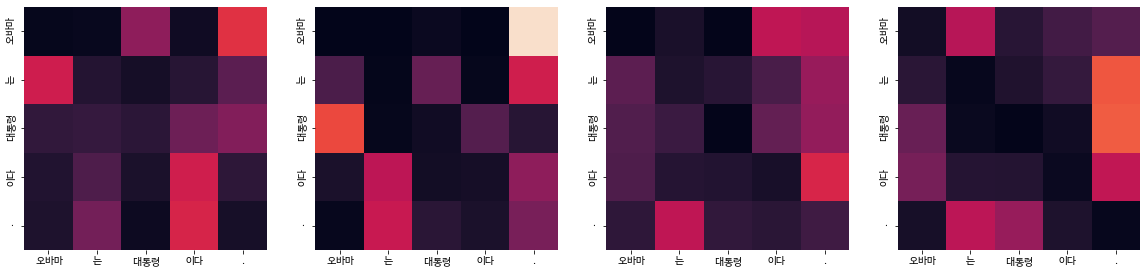

Encoder Layer 2


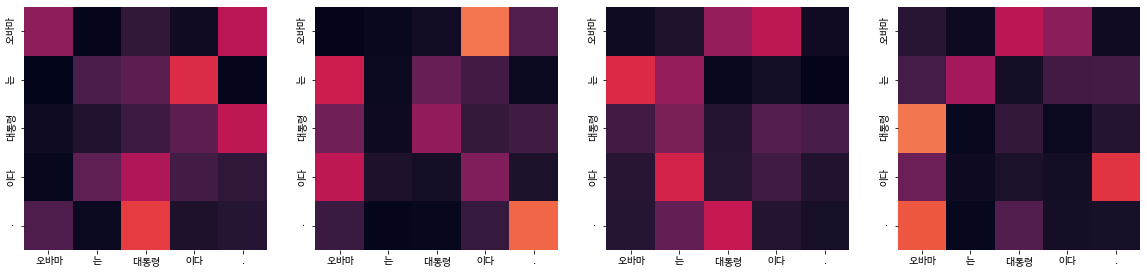

Decoder Self Layer 1


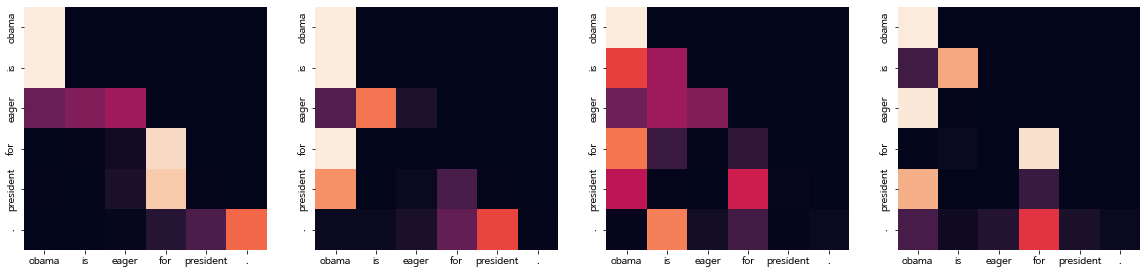

Decoder Src Layer 1


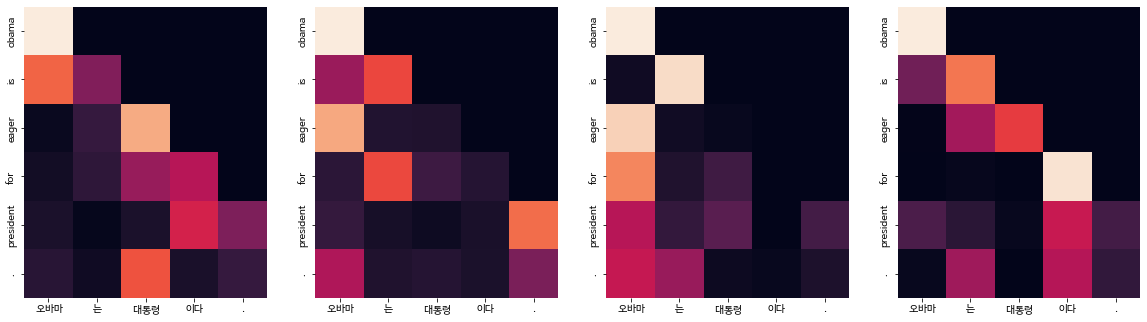

Decoder Self Layer 2


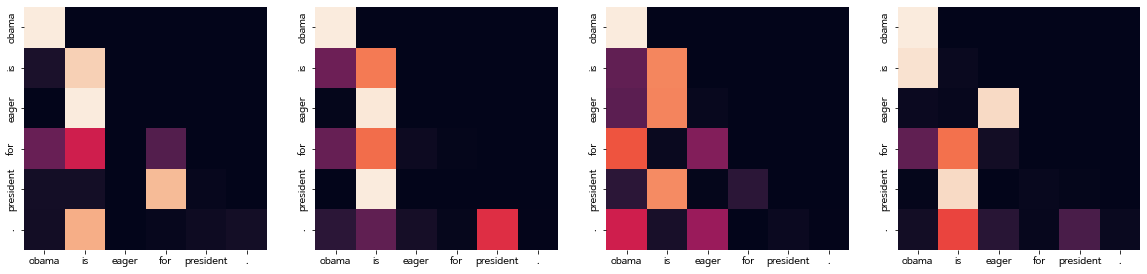

Decoder Src Layer 2


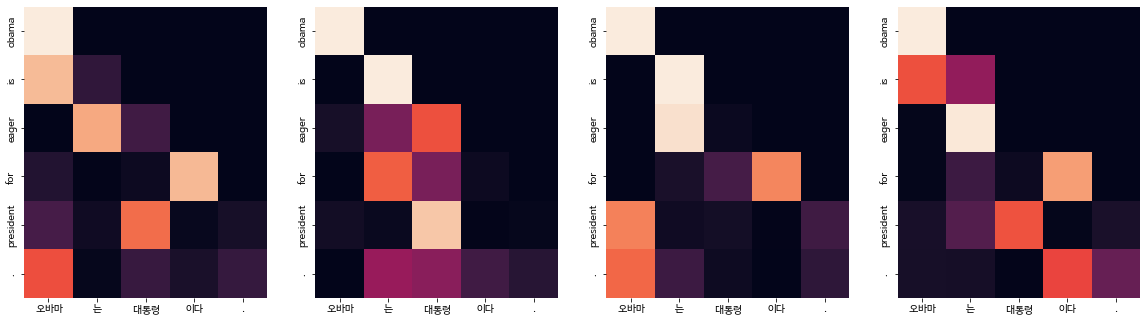

Input: 시민들은 도시 속에 산다.
Predicted translation: they are only a few cities .
Encoder Layer 1


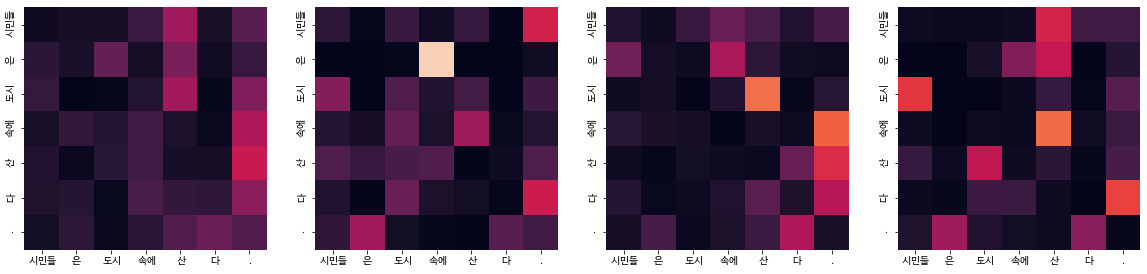

Encoder Layer 2


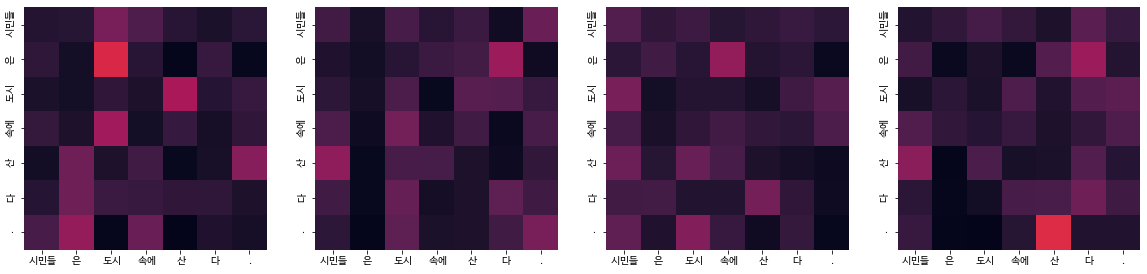

Decoder Self Layer 1


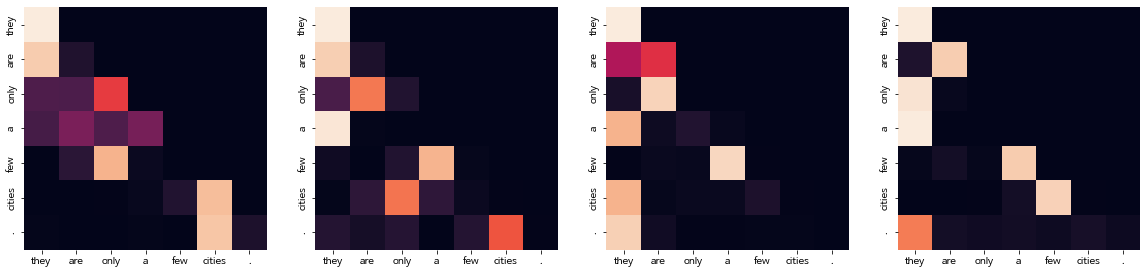

Decoder Src Layer 1


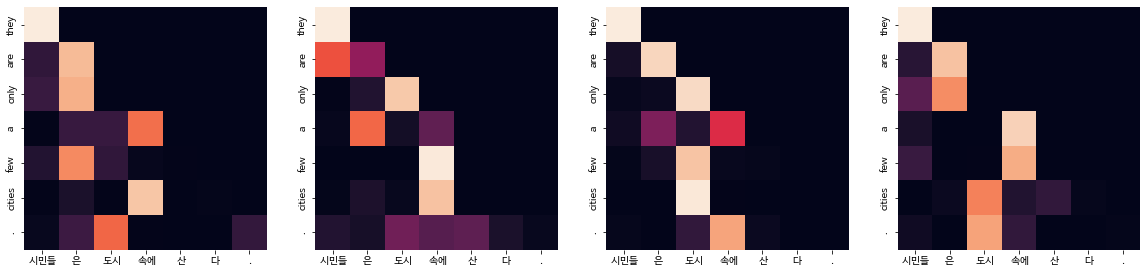

Decoder Self Layer 2


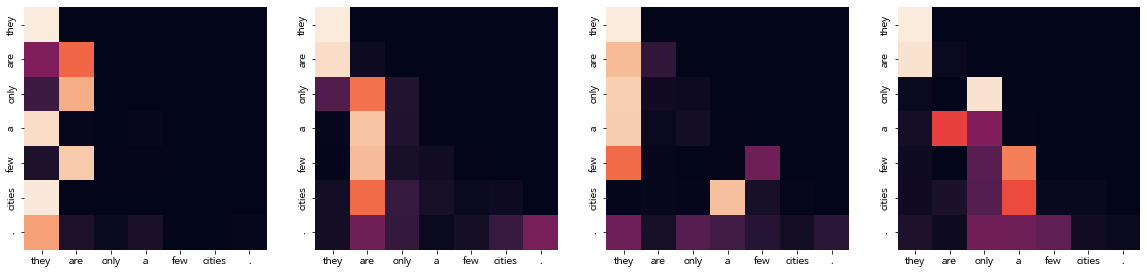

Decoder Src Layer 2


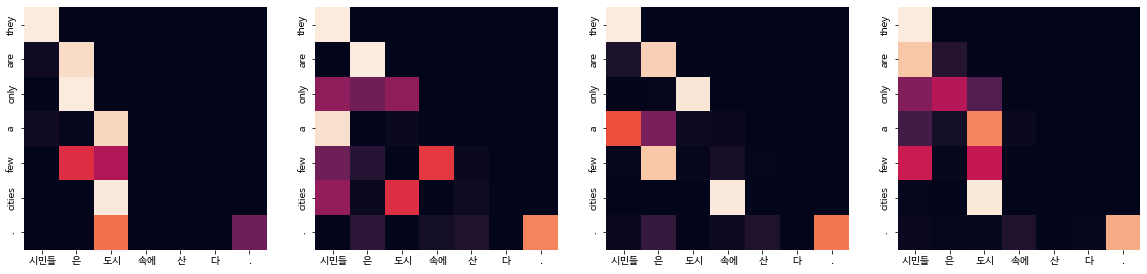

Input: 커피는 필요 없다.
Predicted translation: the coffee doctors need to do more or when the coffee needs .
Encoder Layer 1


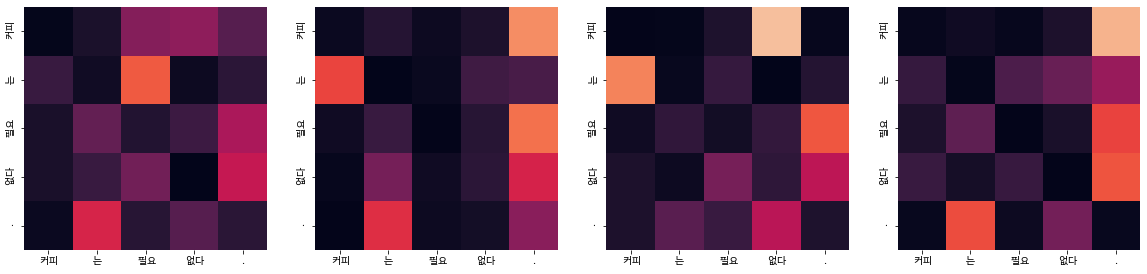

Encoder Layer 2


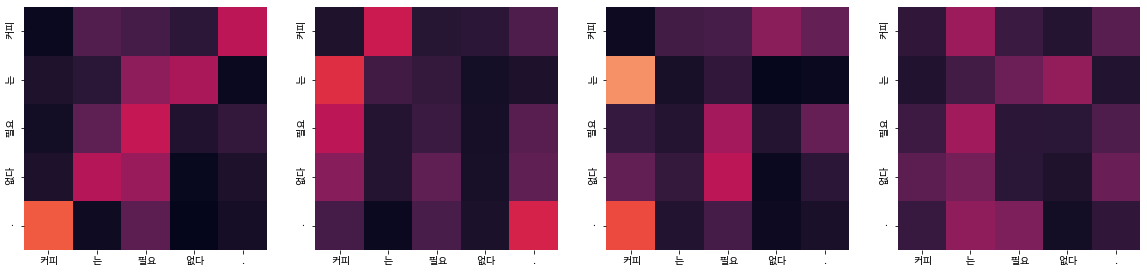

Decoder Self Layer 1


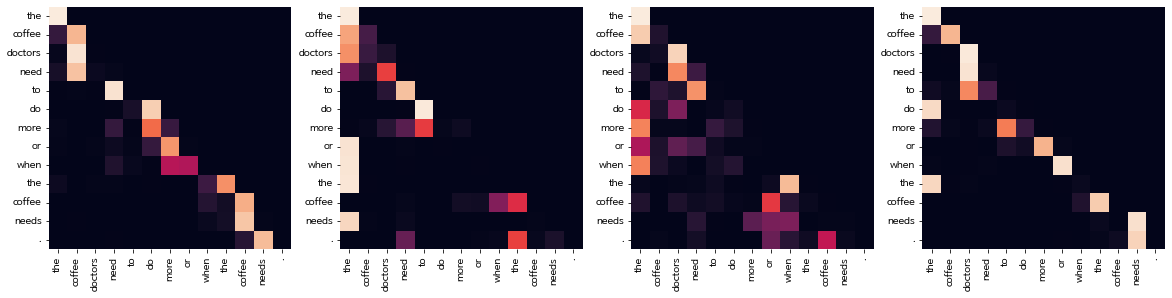

Decoder Src Layer 1


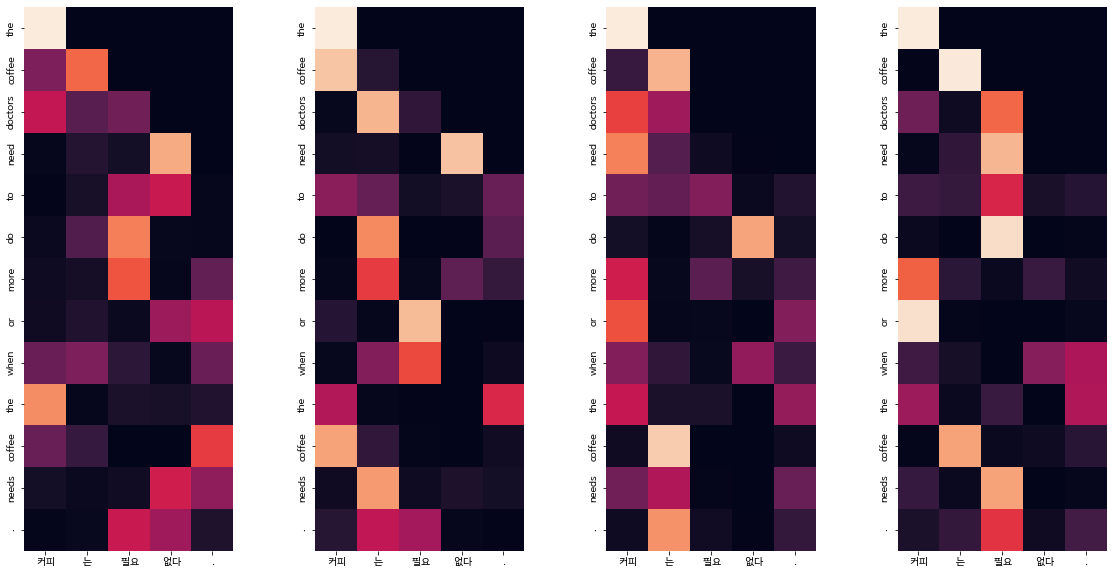

Decoder Self Layer 2


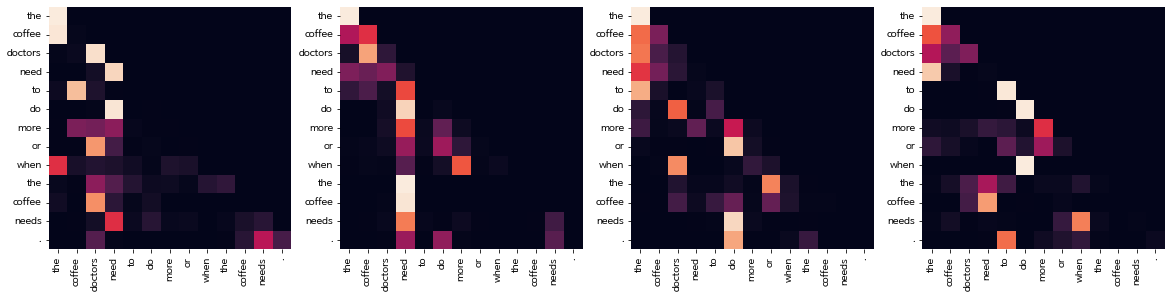

Decoder Src Layer 2


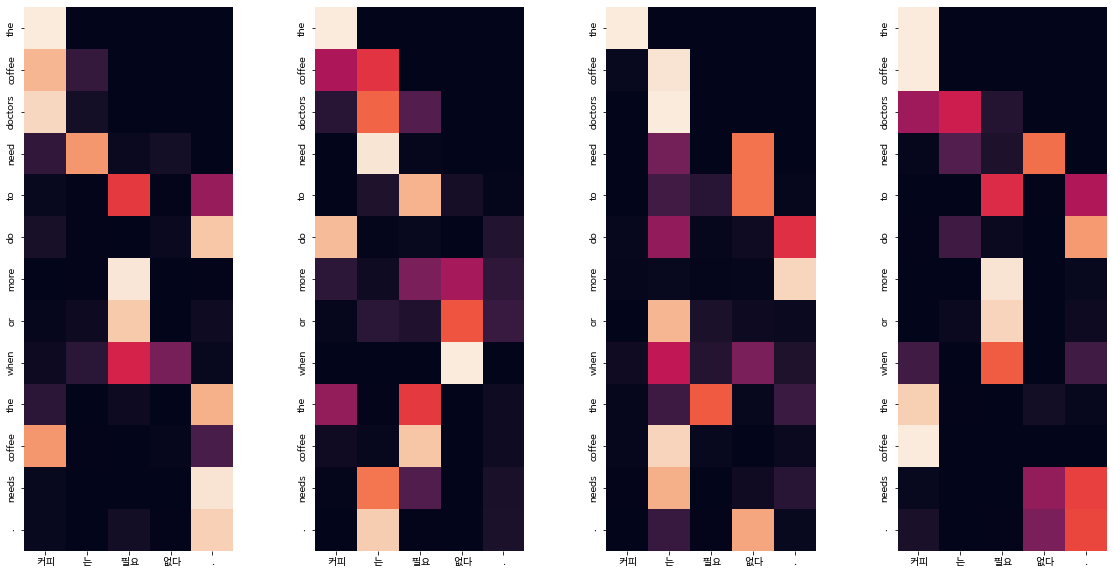

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven of seven killed were being wounded wednesday , according to the seven police department .
Encoder Layer 1


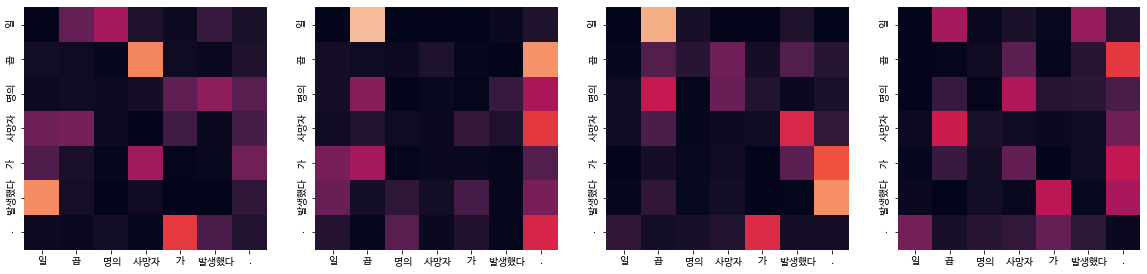

Encoder Layer 2


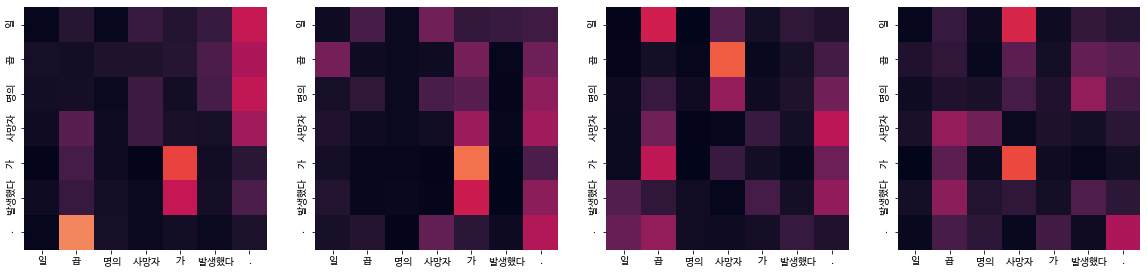

Decoder Self Layer 1


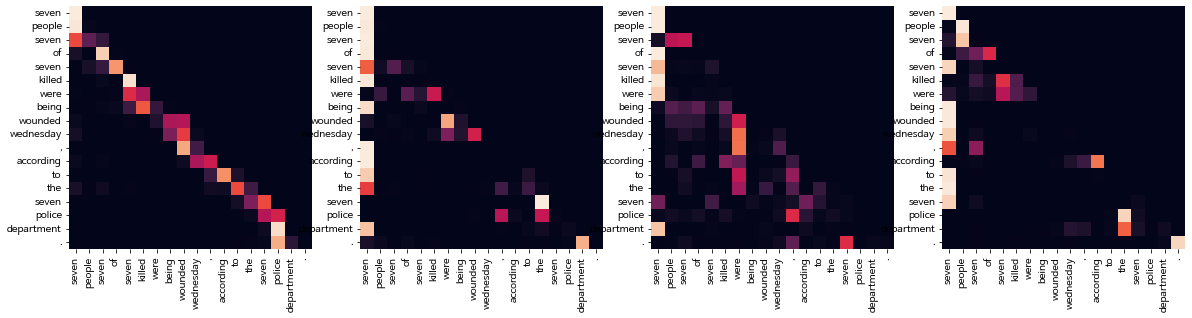

Decoder Src Layer 1


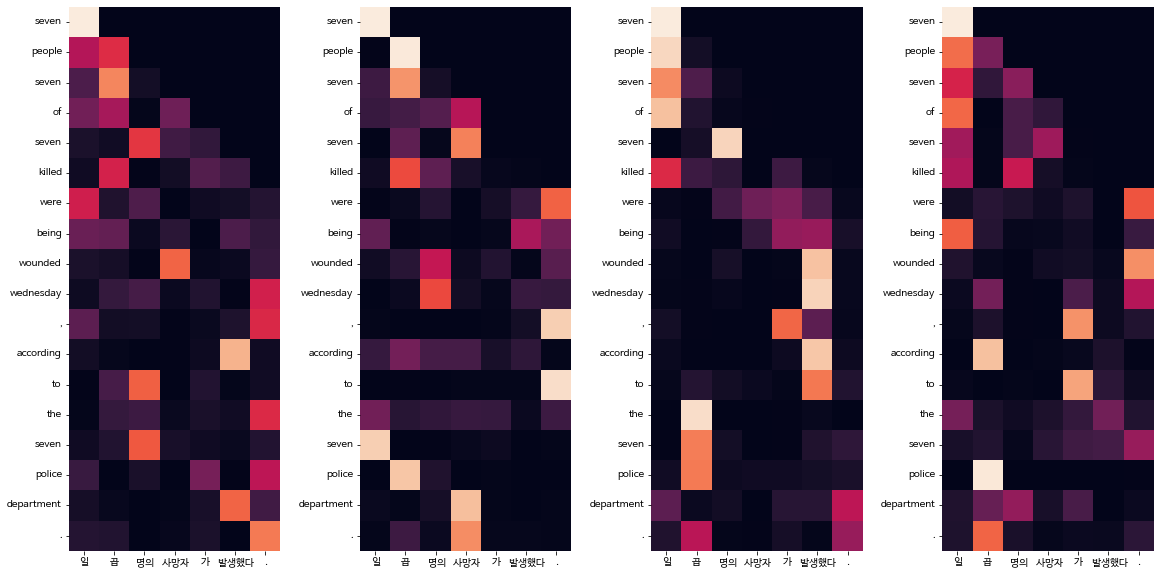

Decoder Self Layer 2


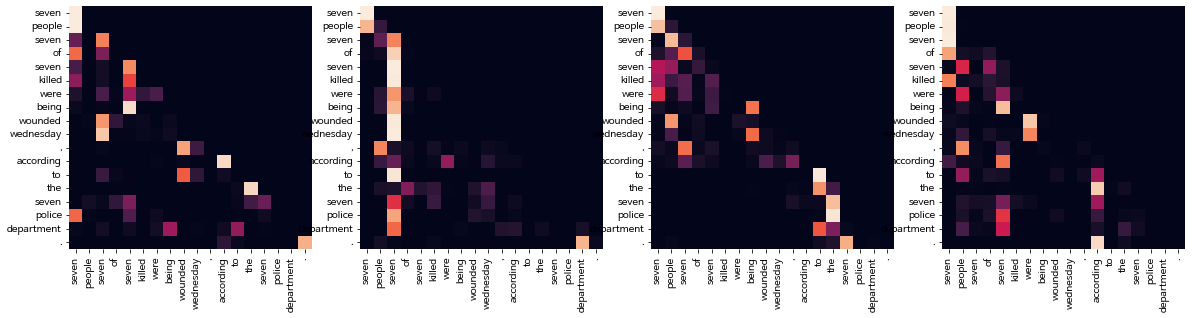

Decoder Src Layer 2


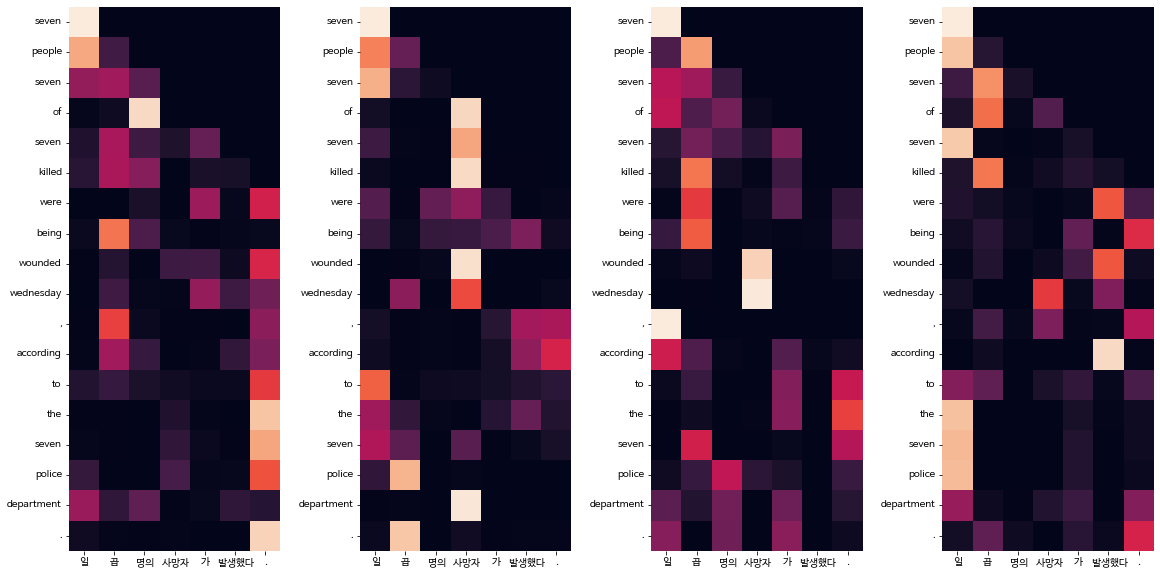

In [31]:
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔고딕 사용

for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

### n_layers=4

In [32]:
transformer2 = Transformer(
    n_layers=4,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

In [35]:
EPOCHS = 20
BATCH_SIZE = 32


# before running second transformer, it is nessesary to initialize train-step above.
for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
                                                                     dec_train[idx:idx+BATCH_SIZE],
                                                                     transformer2,
                                                                     optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    # 매 Epoch 마다 제시된 예문에 대한 번역 생성
    for example in examples:
        translate(example, transformer2, ko_tokenizer, en_tokenizer)

Epoch  1: 100%|██████████| 2255/2255 [07:46<00:00,  4.83it/s, Loss 5.0645]


Input: 오바마는 대통령이다.
Predicted translation: obama is the first time .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city of city city city city city city city city city city city city .
Input: 커피는 필요 없다.
Predicted translation: it s a good time .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least people were killed .


Epoch  2: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 3.9081]


Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the town is the knownest .
Input: 커피는 필요 없다.
Predicted translation: no one need to be able to treat the need of coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll of .


Epoch  3: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 3.2932]


Input: 오바마는 대통령이다.
Predicted translation: the president elect is the most famous president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the temple is the city s most famous city .
Input: 커피는 필요 없다.
Predicted translation: coffee is no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on tuesday , the death toll from the death toll in the death toll .


Epoch  4: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 2.7178]


Input: 오바마는 대통령이다.
Predicted translation: obama is a former president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re calling it a city of cities .
Input: 커피는 필요 없다.
Predicted translation: coffee is a coffee for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the toll in the th fatality occurred monday .


Epoch  5: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 2.1635]


Input: 오바마는 대통령이다.
Predicted translation: obama is a lead in the first town .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re getting the city of san diego city .
Input: 커피는 필요 없다.
Predicted translation: it does not need coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in the u . s .


Epoch  6: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 1.7093]


Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re very happy for the town of around the mountain .
Input: 커피는 필요 없다.
Predicted translation: coffee is no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh person is in the seventh of the seventh deaths .


Epoch  7: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 1.3595]


Input: 오바마는 대통령이다.
Predicted translation: there is a president obama up to . . .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the city of san da award .
Input: 커피는 필요 없다.
Predicted translation: that will be coffeeing and coffee at coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed .


Epoch  8: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 1.1019]


Input: 오바마는 대통령이다.
Predicted translation: the president is hopeful for obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took over the urban town of good cities around the world .
Input: 커피는 필요 없다.
Predicted translation: coffee is no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven died seven to the seven person .


Epoch  9: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.9362]


Input: 오바마는 대통령이다.
Predicted translation: obama s inauguration is a massive president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took over the city to urbanization .
Input: 커피는 필요 없다.
Predicted translation: need to be needed , cup need to be required to become coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven persons were killed monday .


Epoch 10: 100%|██████████| 2255/2255 [07:37<00:00,  4.92it/s, Loss 0.8185]


Input: 오바마는 대통령이다.
Predicted translation: obama will do his best to free .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took over the handling of the building .
Input: 커피는 필요 없다.
Predicted translation: need to need coffee is need to need to need to need to need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed in the fatality seven days before the death of a year old girl , which died on saturday .


Epoch 11: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.7344]


Input: 오바마는 대통령이다.
Predicted translation: obama will do a strong president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took over the urban town of the .
Input: 커피는 필요 없다.
Predicted translation: for coffee is no longer required .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven personnel were killed .


Epoch 12: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.6703]


Input: 오바마는 대통령이다.
Predicted translation: obama is a leader .
Input: 시민들은 도시 속에 산다.
Predicted translation: they neighbored cities around the city .
Input: 커피는 필요 없다.
Predicted translation: not for need , coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven others .


Epoch 13: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.6188]


Input: 오바마는 대통령이다.
Predicted translation: obama is a leading democrat .
Input: 시민들은 도시 속에 산다.
Predicted translation: they went to the city , so the city is steps to lives .
Input: 커피는 필요 없다.
Predicted translation: need to be need to be need to be need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven south korean officials .


Epoch 14: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.5787]


Input: 오바마는 대통령이다.
Predicted translation: the president is poverty .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took over the urban town of urban towns around the city of sans frontieres .
Input: 커피는 필요 없다.
Predicted translation: the need is to send .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh person has died in the past seven to seven , officials said monday .


Epoch 15: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.5433]


Input: 오바마는 대통령이다.
Predicted translation: obama , who is a leading presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took over the urban town of plans to urban fighter .
Input: 커피는 필요 없다.
Predicted translation: the need is no more  coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when a storm of hailra died monday .


Epoch 16: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.5163]


Input: 오바마는 대통령이다.
Predicted translation: the presidential office is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re late on washington state .
Input: 커피는 필요 없다.
Predicted translation: need to do something naturally .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


Epoch 17: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.4903]


Input: 오바마는 대통령이다.
Predicted translation: obama is a democrat .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took over to would call .
Input: 커피는 필요 없다.
Predicted translation: need to be coffee , the need for coffee is no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two people were among the dead .


Epoch 18: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.4675]


Input: 오바마는 대통령이다.
Predicted translation: obama is a former president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they went to cover the urban town of .
Input: 커피는 필요 없다.
Predicted translation: if the need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two people were killed on the seven story when a dutch toll stood on sunday .


Epoch 19: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.4473]


Input: 오바마는 대통령이다.
Predicted translation: obama is a been the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took over their densely populated name .
Input: 커피는 필요 없다.
Predicted translation: the need is to need to be de nk .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed thursday in the seventh of them .


Epoch 20: 100%|██████████| 2255/2255 [07:37<00:00,  4.93it/s, Loss 0.4300]


Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they neighboring cities around the city .
Input: 커피는 필요 없다.
Predicted translation: need to need to be contacted for need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven story


Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Encoder Layer 1


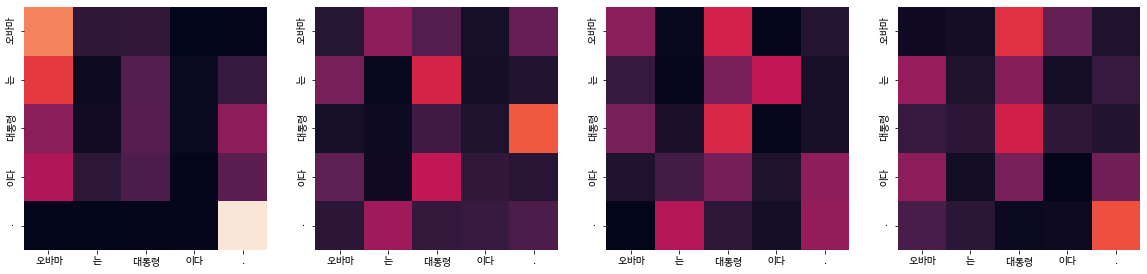

Encoder Layer 2


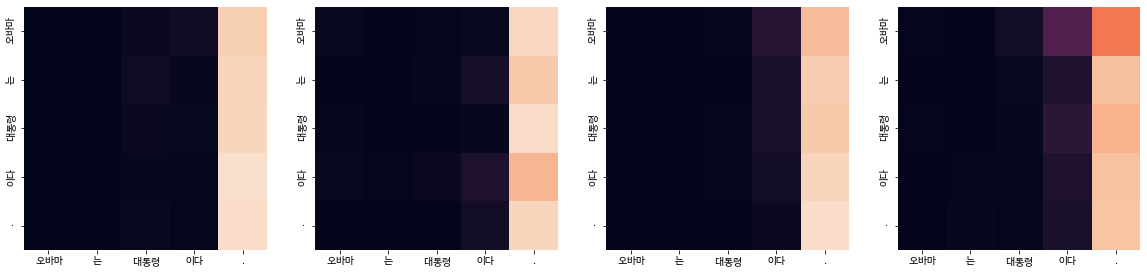

Decoder Self Layer 1


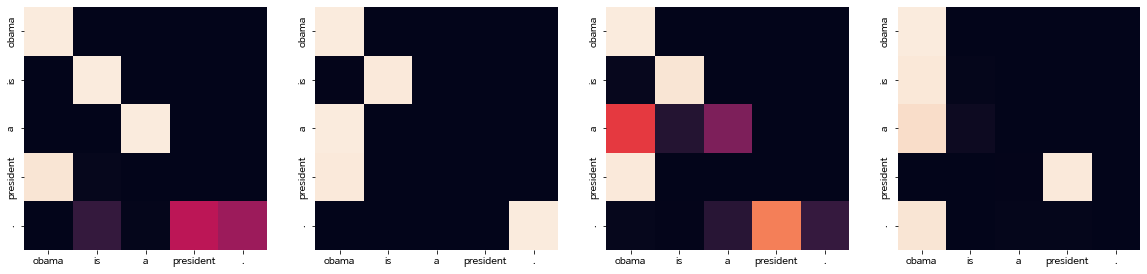

Decoder Src Layer 1


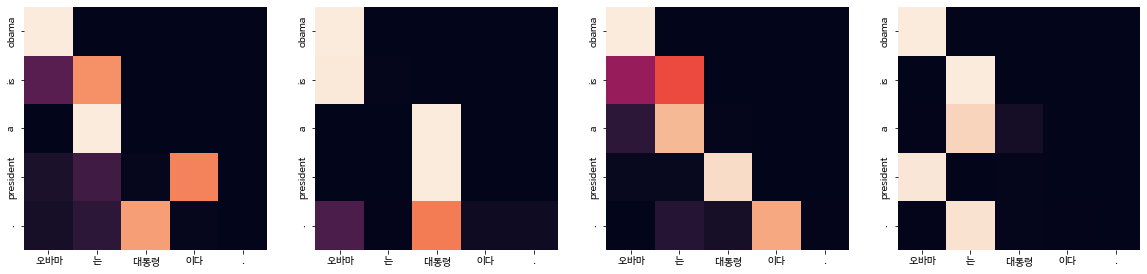

Decoder Self Layer 2


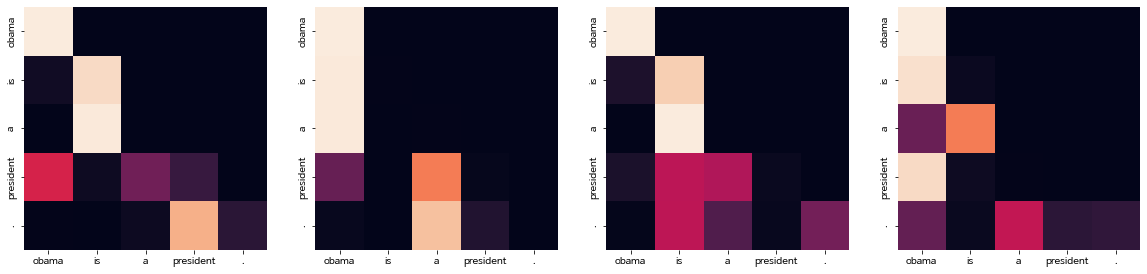

Decoder Src Layer 2


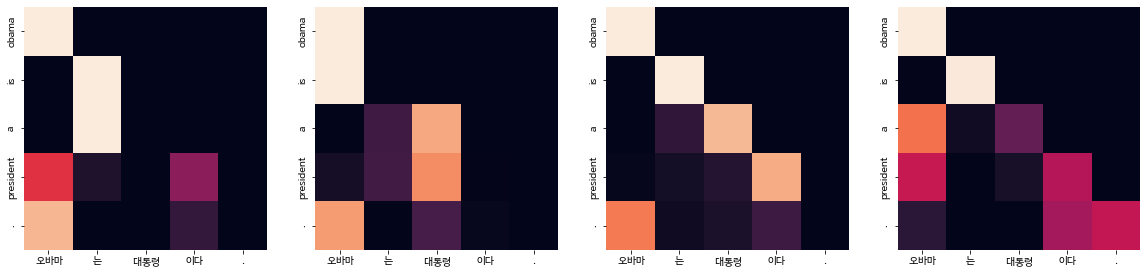

Input: 시민들은 도시 속에 산다.
Predicted translation: they neighboring cities around the city .
Encoder Layer 1


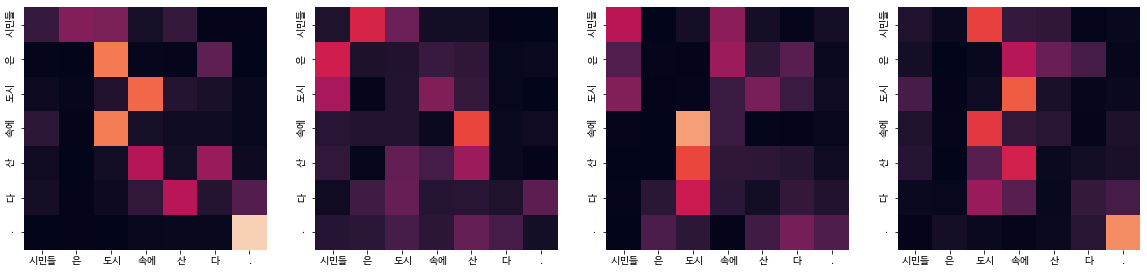

Encoder Layer 2


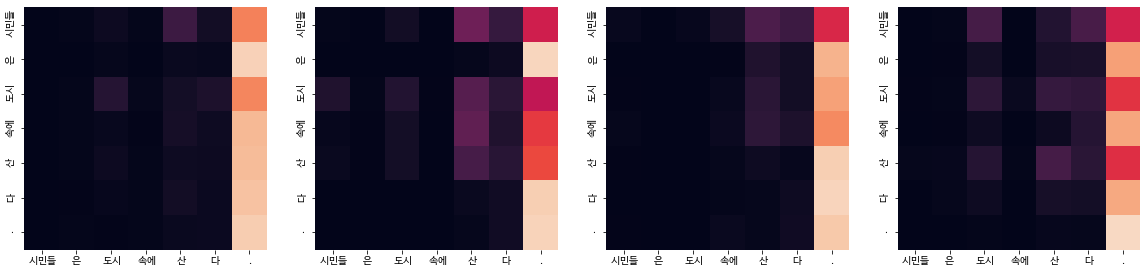

Decoder Self Layer 1


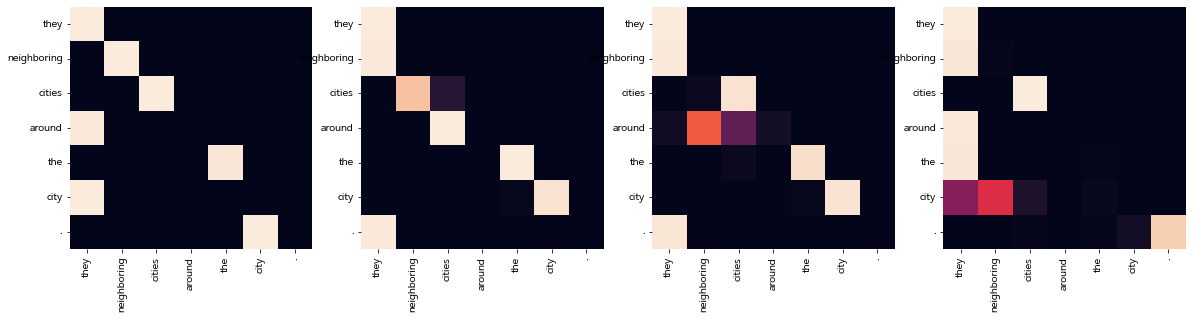

Decoder Src Layer 1


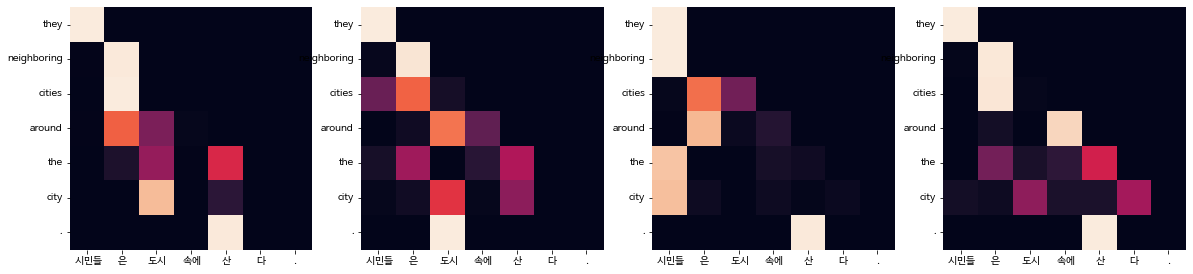

Decoder Self Layer 2


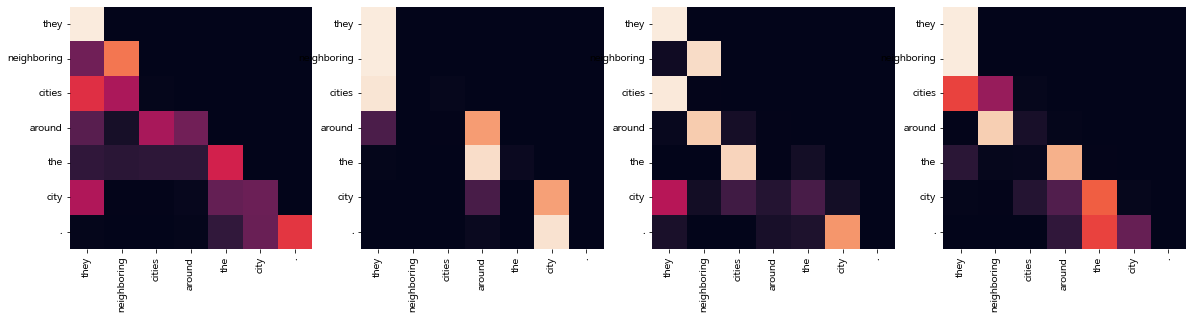

Decoder Src Layer 2


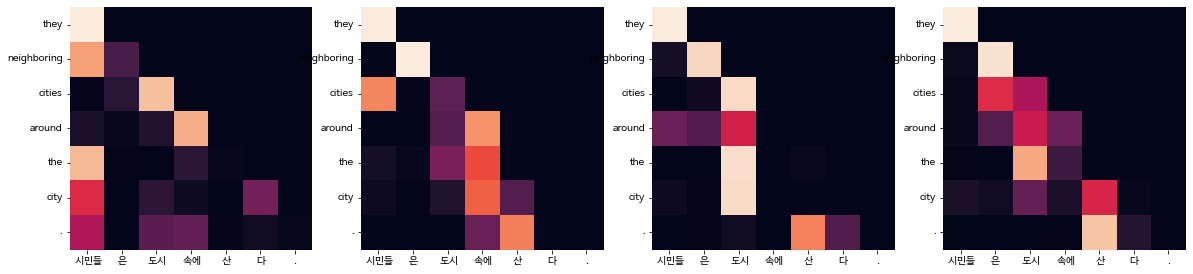

Input: 커피는 필요 없다.
Predicted translation: need to need to be contacted for need .
Encoder Layer 1


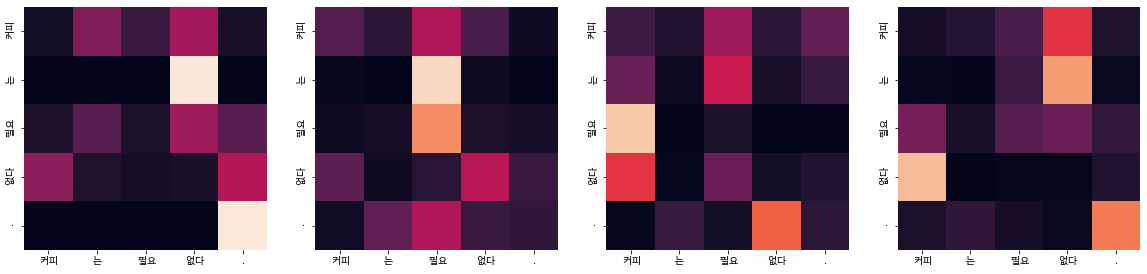

Encoder Layer 2


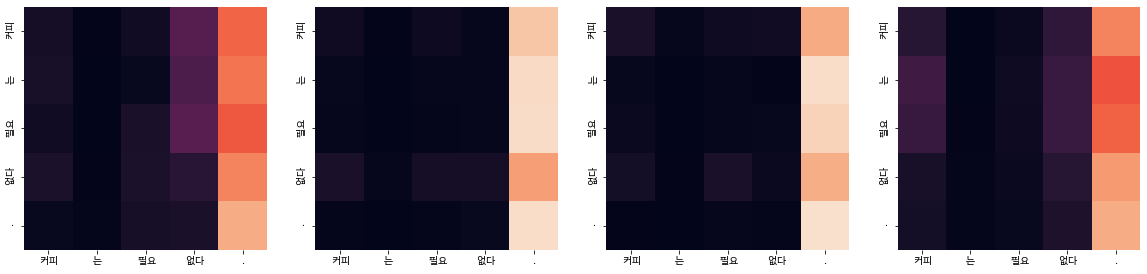

Decoder Self Layer 1


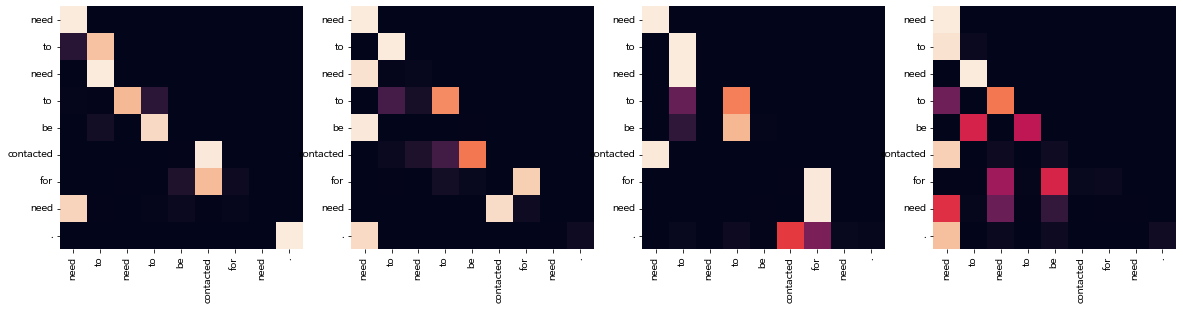

Decoder Src Layer 1


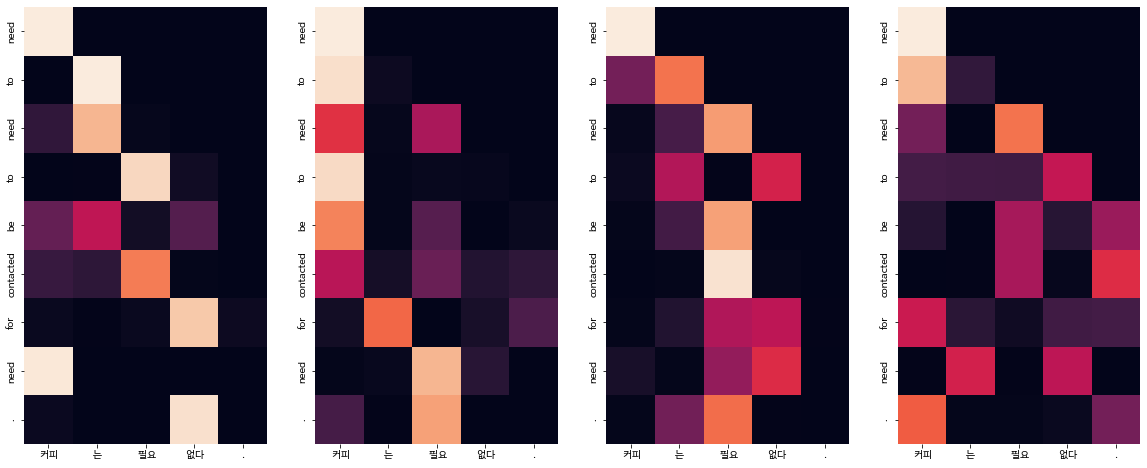

Decoder Self Layer 2


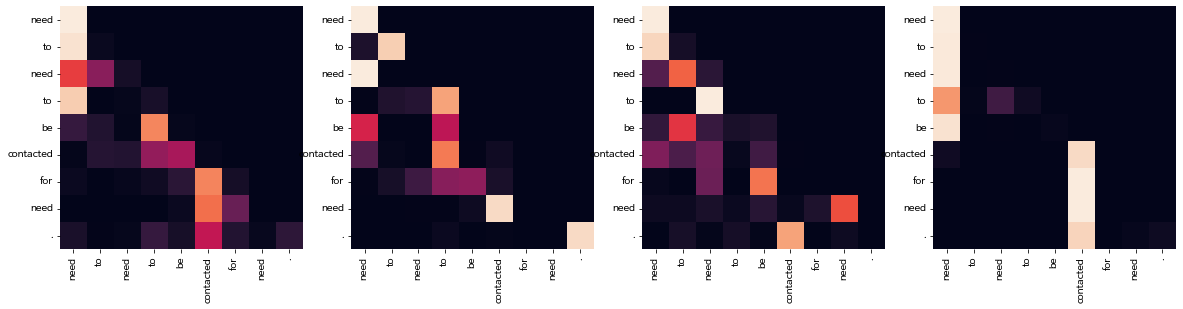

Decoder Src Layer 2


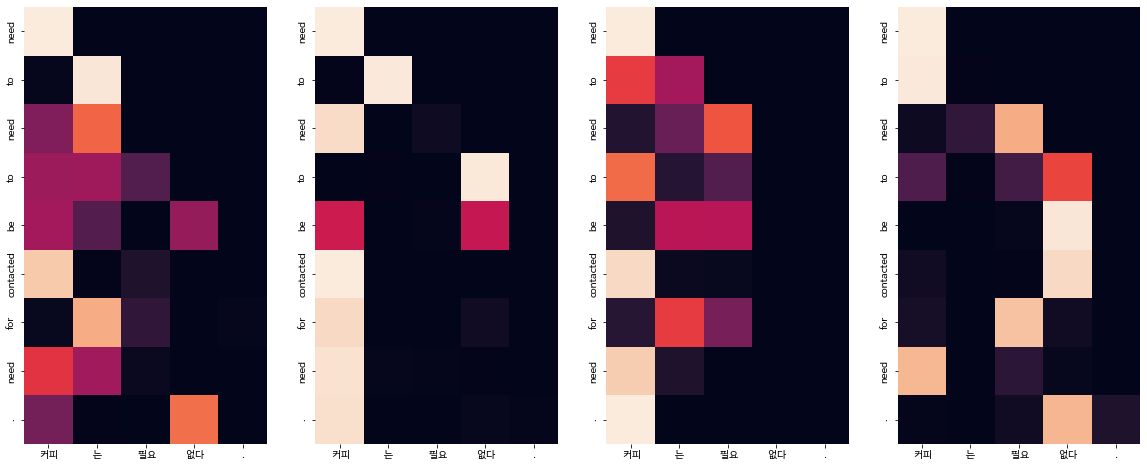

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven story
Encoder Layer 1


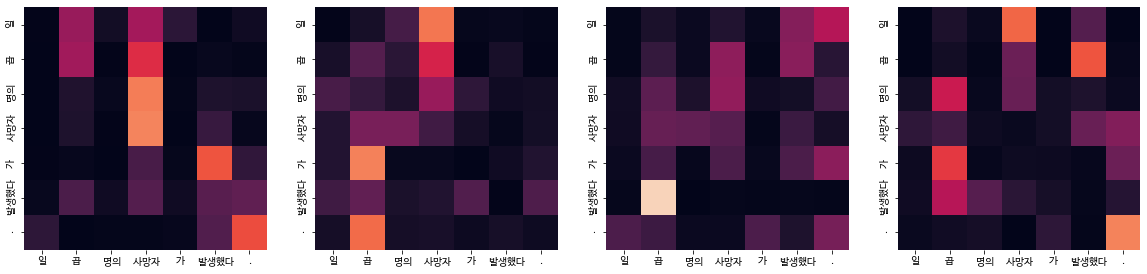

Encoder Layer 2


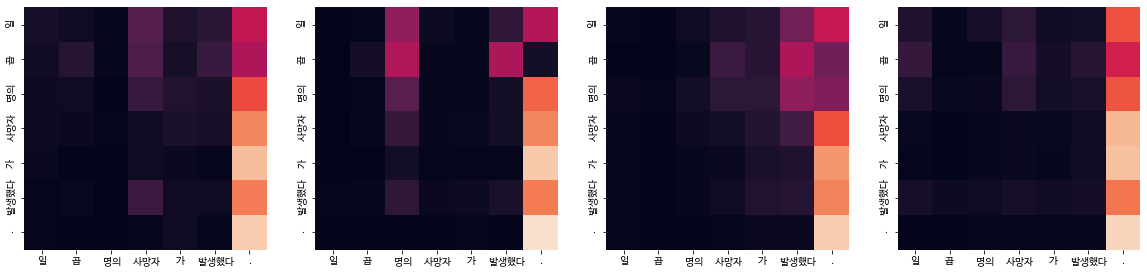

Decoder Self Layer 1


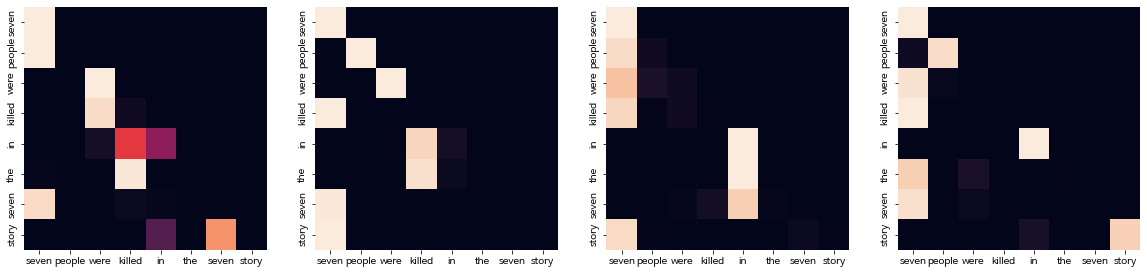

Decoder Src Layer 1


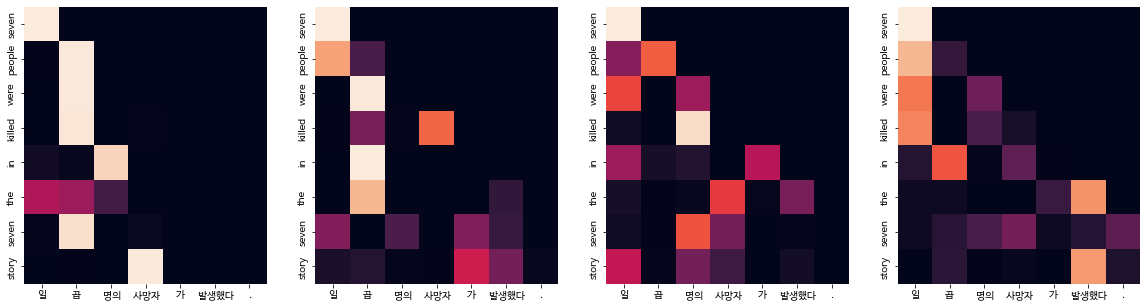

Decoder Self Layer 2


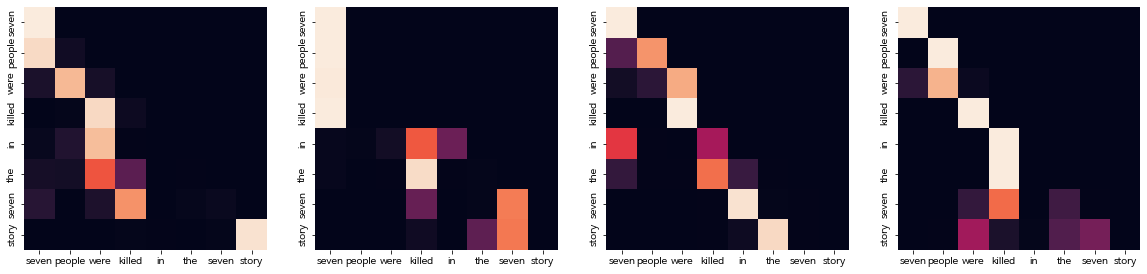

Decoder Src Layer 2


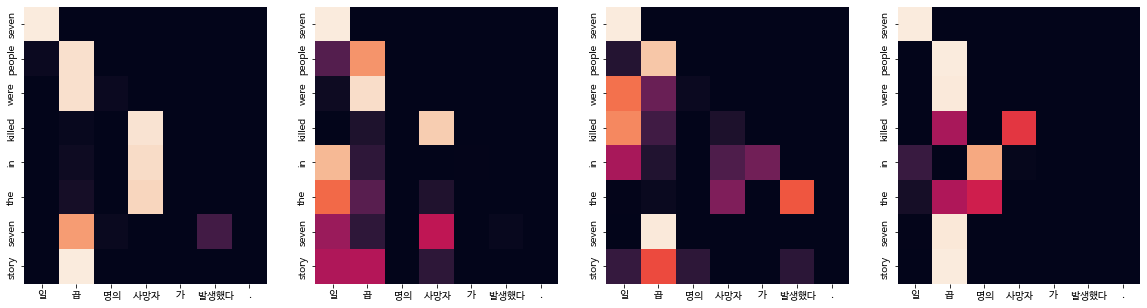

In [36]:
for example in examples:
    translate(example, transformer2, ko_tokenizer, en_tokenizer, plot_attention=True)

## Summary


|                       | transformer(n_layers=2)                                                                 | transformer2(n_layers=4)                                                                                     |
|-----------------------|-----------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| 오바마는 대통령이다.     | obama is eager for president.                                                           | obama is a president.                                                                                        |
| 시민들은 도시 속에 산다. | they are only a few cities.                                                             | they neighboring cities around the city.                                                                     |
| 커피는 필요 없다.        | the coffee doctors need to do more or when the coffee needs.                            | need to need to be contacted for need.                                                                       |
| 일곱 명의 사망자가 발생했다. | seven people seven of seven killed were being wounded wednesday, according to the seven police department. | seven people were killed in the seven story.                                                                |


n_layers=4 results were better than n_layers=2.

Best cases for each sentances:

|                       | transformer2(n_layers=4)(epochs)                              |condition|
|-----------------------|-------------------------------------------------------|---|
| 오바마는 대통령이다.     | obama is a president.(20)                                 |sweet spot|
| 시민들은 도시 속에 산다. |  (underfitted)              |underfitted|
| 커피는 필요 없다.        | not for need , coffee(12)               |overfitted at 20 epoch|
| 일곱 명의 사망자가 발생했다. | seven people were killed .(16)         |overfitted at 20 epoch|

I think this model need a bit more complexity. It'll be better to use n_layers=5 or 6. 